In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [3]:
# see how many images are there for each digit
for j in np.arange(10):
    idx = np.where(y==str(j))
    idx = np.asarray(idx)[0,:]
    print('digit %i length %i' % (j, len(idx)))

digit 0 length 6903
digit 1 length 7877
digit 2 length 6990
digit 3 length 7141
digit 4 length 6824
digit 5 length 6313
digit 6 length 6876
digit 7 length 7293
digit 8 length 6825
digit 9 length 6958


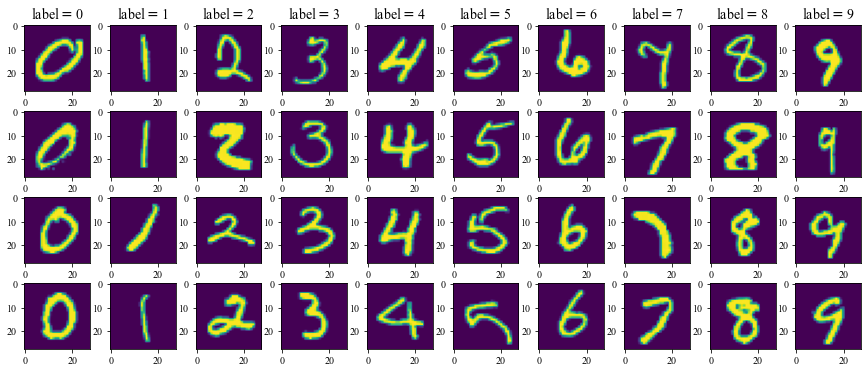

In [4]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        idx = np.where(y==str(j)) # index of all images of digit 'j'
        idx = np.asarray(idx)[0,:] # make idx from tuple to array
        idx_subsampled = np.random.choice(idx, nrows)
        ax[i,j].imshow(X[idx_subsampled[i],:].reshape(28,28))
        # ax[i,j].title.set_text("label=%s" % y[idx_subsampled[j]]) 
        if i == 0:
            # ax[j,i].set_ylabel("label=%s" % y[idx_subsampled[j]]) 
            ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('MNIST_ex1.pdf', bbox_inches='tight')

In [5]:

# Split the dataset into train and test sets

X_train = []
X_test = []
y_test = []
y_train = []
for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U<0.8:
        X_train.append(X[i,:])
        y_train.append(y[i])
    else:
        X_test.append(X[i,:])
        y_test.append(y[i])
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (55984, 784)
X_test.shape (14016, 784)
y_train.shape (55984,)
y_test.shape (14016,)


In [6]:
def sample_binary_MNIST(list_digits=['0','1'], full_MNIST=None):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s
    
    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        label = 0
        if y01[i] == str(list_digits[1]):
            label = 1

        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(label)
        else:
            X_test.append(X01[i,:])
            y_test.append(label)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).reshape(-1,1)
    y_test = np.asarray(y_test).reshape(-1,1)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test, sample_binary_MNIST(list_digits=['0','1'], full_MNIST=[X, y])
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (55984, 784)
X_test.shape (14016, 784)
y_train.shape (55984,)
y_test.shape (14016,)


In [7]:
def fit_PR_GD(Y, H, W0=None, sub_iter=10, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            loss = 0
            j = 0
            for j in np.arange (Y.shape[0]):
                loss = (-1) * (Y[j,0]*np.log(norm.cdf(H[:,j].T @ W1)) + (1-Y[j,0])*np.log(norm.cdf(-H[:,j].T @ W1))) + loss
            loss_list = np.append(loss_list,loss)
            print('iter %i, loss %f' %(i, loss))
        return W1, loss_list

iter 1, loss 8334.403274
iter 2, loss 7739.939892
iter 3, loss 7084.721934
iter 4, loss 6485.186194
iter 5, loss 5959.477323
iter 6, loss 5502.218157
iter 7, loss 5103.681479
iter 8, loss 4754.585617
iter 9, loss 4447.067695
iter 10, loss 4174.671058
iter 11, loss 3932.121074
iter 12, loss 3715.093610
iter 13, loss 3520.021573
iter 14, loss 3343.942246
iter 15, loss 3184.378508
iter 16, loss 3039.246309
iter 17, loss 2906.782123
iter 18, loss 2785.485607
iter 19, loss 2674.073902
iter 20, loss 2571.444932
iter 21, loss 2476.647720
iter 22, loss 2388.858225
iter 23, loss 2307.359548
iter 24, loss 2231.525638
iter 25, loss 2160.807806
iter 26, loss 2094.723503
iter 27, loss 2032.846952
iter 28, loss 1974.801283
iter 29, loss 1920.251909
iter 30, loss 1868.900921
iter 31, loss 1820.482334
iter 32, loss 1774.758034
iter 33, loss 1731.514311
iter 34, loss 1690.558889
iter 35, loss 1651.718368
iter 36, loss 1614.836014
iter 37, loss 1579.769854
iter 38, loss 1546.391009
iter 39, loss 1514.58

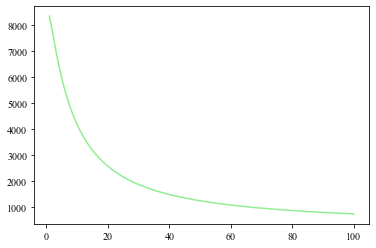

In [8]:
from scipy.stats import norm

def probit(x):
    return norm.cdf(x)

X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=['0','1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 

W,loss_list = fit_PR_GD(Y=y_train, H=H_train/1000,sub_iter=100) 

fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 100, 100)
ax.plot(x, loss_list, color='lightgreen', label="loss")


In [9]:
def fit_PR_GD_2(Y, H, W0=None, sub_iter=10, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - (10*np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            loss = 0
            j = 0
            for j in np.arange (Y.shape[0]):
                loss = (-1) * (Y[j,0]*np.log(norm.cdf(H[:,j].T @ W1)) + (1-Y[j,0])*np.log(norm.cdf(-H[:,j].T @ W1))) + loss
            loss_list = np.append(loss_list,loss)
            #print('iter %i, loss %f' %(i, loss))
        return W1, loss_list

def fit_PR_GD_3(Y, H, W0=None, sub_iter=10, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - grad
            i = i + 1
            loss = 0
            j = 0
            for j in np.arange (Y.shape[0]):
                loss = (-1) * (Y[j,0]*np.log(norm.cdf(H[:,j].T @ W1)) + (1-Y[j,0])*np.log(norm.cdf(-H[:,j].T @ W1))) + loss
            loss_list = np.append(loss_list,loss)
            #print('iter %i, loss %f' %(i, loss))
        return W1, loss_list
    
def fit_PR_GD_4(Y, H, W0=None, sub_iter=10, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter+1) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - (1/(i+1)) * grad
            i = i + 1
            loss = 0
            j = 0
            for j in np.arange (Y.shape[0]):
                loss = (-1) * (Y[j,0]*np.log(norm.cdf(H[:,j].T @ W1)) + (1-Y[j,0])*np.log(norm.cdf(-H[:,j].T @ W1))) + loss
            loss_list = np.append(loss_list,loss)
            #print('iter %i, loss %f' %(i, loss))
        return W1, loss_list

X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=['0','1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 

W2,loss_list_2 = fit_PR_GD_2(Y=y_train, H=H_train/1000,sub_iter=100)
W3,loss_list_3 = fit_PR_GD_3(Y=y_train, H=H_train/1000,sub_iter=100)
W4,loss_list_4 = fit_PR_GD_4(Y=y_train, H=H_train/1000,sub_iter=100)

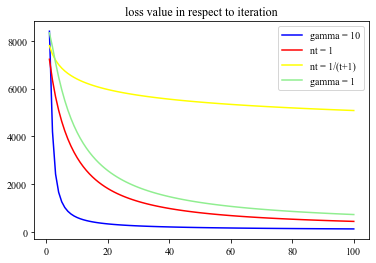

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 100, 100)
ax.plot(x, loss_list_2, color='blue', label="gamma = 10")
ax.plot(x, loss_list_3, color='red', label="nt = 1")
ax.plot(x, loss_list_4, color='yellow', label="nt = 1/(t+1)")
ax.plot(x, loss_list, color='lightgreen', label="gamma = 1")
ax.title.set_text("loss value in respect to iteration")
ax.legend()

In [11]:
def fit_PR_GD_5(Y, H, W0=None, sub_iter=10, stopping_diff=0.01, gamma = 1, delta = 0.5):
        if W0 is None:
             W0 = np.zeros((H.shape[0],1)) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 1
        grad = np.ones(W0.shape)
        loss_list = np.array([])
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - gamma*(i**(-delta))*grad
            i = i + 1
            loss = 0
            j = 0
            for j in np.arange (Y.shape[0]):
                loss = (-1) * (Y[j,0]*np.log(norm.cdf(H[:,j].T @ W1)) + (1-Y[j,0])*np.log(norm.cdf(-H[:,j].T @ W1))) + loss
            loss_list = np.append(loss_list,loss)
            #print('iter %i, loss %f' %(i, loss))
        return W1, loss_list

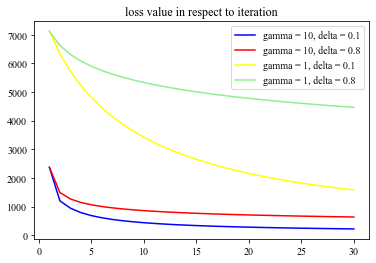

In [12]:
X_train, X_test, y_train, y_test = sample_binary_MNIST(list_digits=['0','1'], full_MNIST = [X,y])
H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 

W5,loss_list_5 = fit_PR_GD_5(Y=y_train, H=H_train/1000,sub_iter=31,gamma = 10, delta = 0.1)
W6,loss_list_6 = fit_PR_GD_5(Y=y_train, H=H_train/1000,sub_iter=31,gamma = 10, delta = 0.8)
W7,loss_list_7 = fit_PR_GD_5(Y=y_train, H=H_train/1000,sub_iter=31,gamma = 1, delta = 0.1)
W7,loss_list_8 = fit_PR_GD_5(Y=y_train, H=H_train/1000,sub_iter=31,gamma = 1, delta = 0.8)

fig, ax = plt.subplots(nrows=1, ncols=1)
x = np.linspace(1, 30, 30)
ax.plot(x, loss_list_5, color='blue', label="gamma = 10, delta = 0.1")
ax.plot(x, loss_list_6, color='red', label="gamma = 10, delta = 0.8")
ax.plot(x, loss_list_7, color='yellow', label="gamma = 1, delta = 0.1")
ax.plot(x, loss_list_8, color='lightgreen', label="gamma = 1, delta = 0.8")
ax.title.set_text("loss value in respect to iteration")
ax.legend()

In [13]:
def sample_binary_MNIST_mod(list_digits=['0','1'], full_MNIST=None, noise_ratio=0.5):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s
    
    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        label = 0
        
        if y01[i] == str(list_digits[1]):
            label = 1
        
        noise_list = np.zeros(X01.shape[1])
        random_noise = np.asarray(np.random.uniform(0,1,X01.shape[1]))
        random_index = np.random.choice(np.arange(X01.shape[1]),int(X01.shape[1]*noise_ratio),replace = False)
        noise_list[random_index] = random_noise[random_index]
        
        if U<0.8:
            X_train.append(X01[i,:]+noise_list)
            y_train.append(label)
        else:
            X_test.append(X01[i,:]+noise_list)
            y_test.append(label)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).reshape(-1,1)
    y_test = np.asarray(y_test).reshape(-1,1)
    
    
    
    return X_train, X_test, y_train, y_test

In [14]:
def fit_LR_GD(Y, H, W0=None, sub_iter=20, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) 
        
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
        return W1

In [15]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False):
    # y_test = binary label 
    # Q = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = Q.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    return results_dict

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


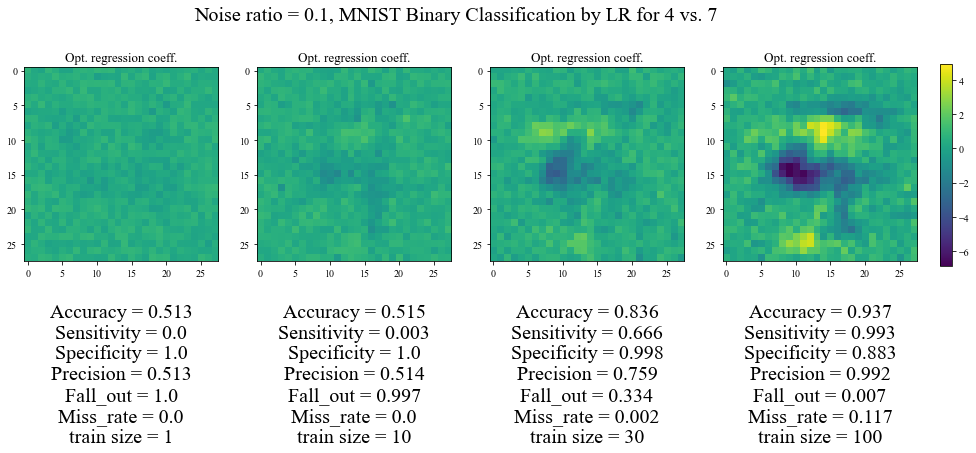

In [16]:
# fit logistic regression using GD and compute binary classification accuracies

# Get train and test data 
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST_mod(digits_list, full_MNIST = [X,y],noise_ratio=0.1)
print(y_train)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model 
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
    W = fit_LR_GD(Y=y_train0, H=H_train0/100, sub_iter=100)  # reduce the scale of H for numerical stability 
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop 

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("Noise ratio = 0.1, MNIST Binary Classification by LR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex1.png', bbox_inches='tight')

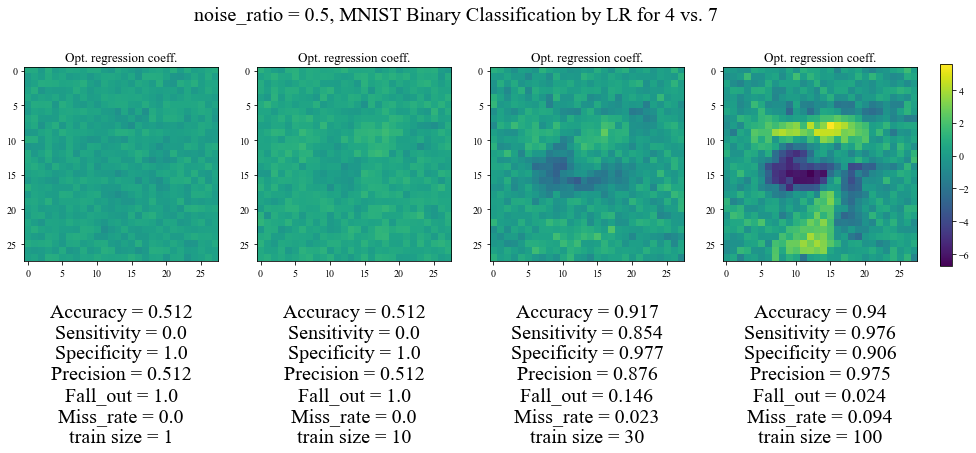

In [17]:
# fit logistic regression using GD and compute binary classification accuracies

# Get train and test data 
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST_mod(digits_list, full_MNIST = [X,y],noise_ratio=0.5)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model 
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
    W = fit_LR_GD(Y=y_train0, H=H_train0/100, sub_iter=100)  # reduce the scale of H for numerical stability 
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop 

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("noise_ratio = 0.5, MNIST Binary Classification by LR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex2.png', bbox_inches='tight')

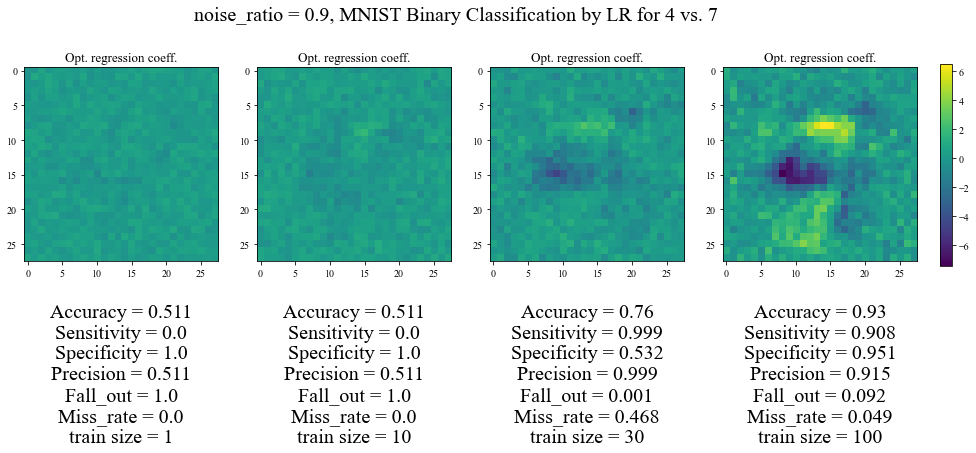

In [18]:
# fit logistic regression using GD and compute binary classification accuracies

# Get train and test data 
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST_mod(digits_list, full_MNIST = [X,y],noise_ratio=0.9)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model 
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
    W = fit_LR_GD(Y=y_train0, H=H_train0/100, sub_iter=100)  # reduce the scale of H for numerical stability 
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop 

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("noise_ratio = 0.9, MNIST Binary Classification by LR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex3.png', bbox_inches='tight')

In [19]:
def fit_PR_GD_clean(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        if W0 is None:
            W0 = np.random.rand(H.shape[0],1) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = norm.pdf(H.T @ W1) * ( (1-Y)/norm.cdf(-H.T @ W1) - Y/norm.cdf(H.T @ W1) )
            grad = H @ Q
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
        return W1

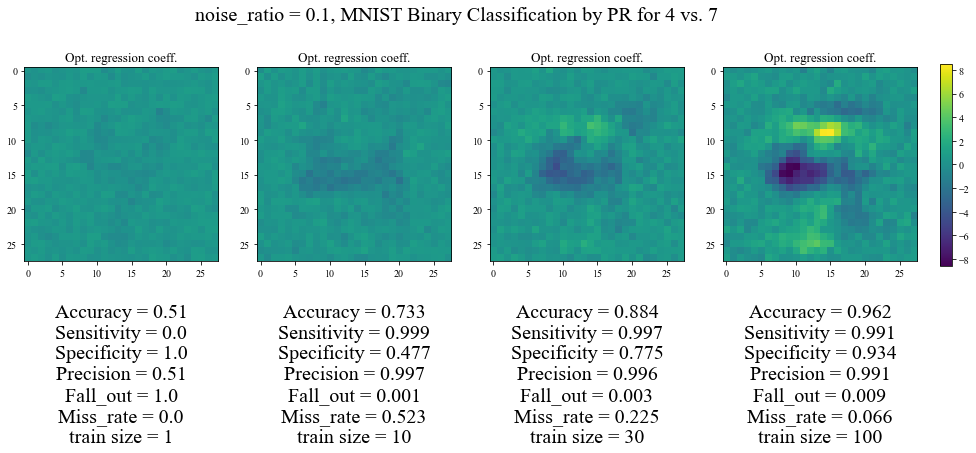

In [20]:
# fit probit regression using GD and compute binary classification accuracies

# Get train and test data 
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST_mod(digits_list, full_MNIST = [X,y],noise_ratio=0.1)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model 
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
    W = fit_PR_GD_clean(Y=y_train0, H=H_train0/100, sub_iter=100)  # reduce the scale of H for numerical stability 
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop 

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("noise_ratio = 0.1, MNIST Binary Classification by PR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex4.png', bbox_inches='tight')

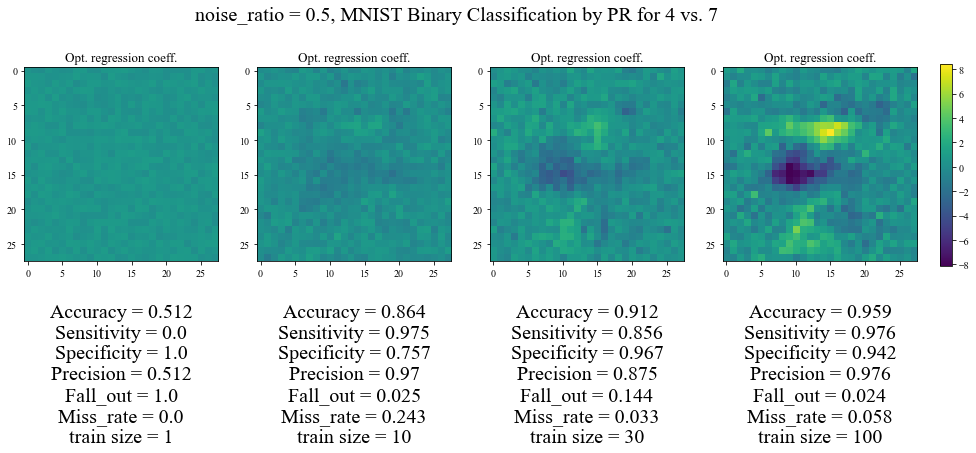

In [21]:
# fit probit regression using GD and compute binary classification accuracies

# Get train and test data 
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST_mod(digits_list, full_MNIST = [X,y],noise_ratio=0.5)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model 
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
    W = fit_PR_GD_clean(Y=y_train0, H=H_train0/100, sub_iter=100)  # reduce the scale of H for numerical stability 
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop 

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("noise_ratio = 0.5, MNIST Binary Classification by PR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex5.png', bbox_inches='tight')

<ipython-input-15-b61b398ad59c>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)


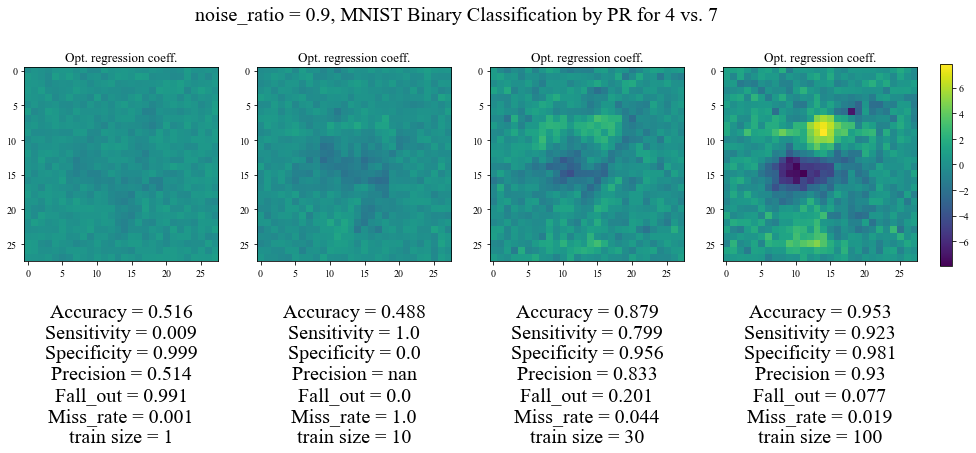

In [22]:
# fit probit regression using GD and compute binary classification accuracies

# Get train and test data 
digits_list = ['4', '7']
X_train, X_test, y_train, y_test = sample_binary_MNIST_mod(digits_list, full_MNIST = [X,y],noise_ratio=0.9)
# Feature matrix of size (p x n) = (feature dim x samples)

list_train_size = [1,10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(y_train)), size)
    X_train0 = X_train[idx, :]
    y_train0 = y_train[idx]

    # Train the logistic regression model 
    H_train0 = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
    W = fit_PR_GD_clean(Y=y_train0, H=H_train0/100, sub_iter=100)  # reduce the scale of H for numerical stability 
    W_list.append(W.copy()) # make sure use copied version of W since the same name is overrided in the loop 

    # Get predicted probabilities 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = 1 / (1 + np.exp(-H_test.T @ W)) # predicted probabilities for y_test

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test=y_test, P_pred = Q)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())

# make plot
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i][1:,:] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("noise_ratio = 0.9, MNIST Binary Classification by PR for %s vs. %s" % (digits_list[0], digits_list[1]), fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('PR_MNIST_test_ex6.png', bbox_inches='tight')